# **East Africa drought study - model fitting**

In [1]:
source("../methods_extRemes.r")
library("copula")

# load precip data and convert to log for fitting purposes
# df <- read.csv("data/gmst-nino-chirps.csv")
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log(df[,v])))

---
## **New methods used in this analysis**

In [123]:
# functions to estimate parameters of fixed-dispersion nonstationary normal distribution
                                                       
norm_fixeddisp_2cov <- function(pars = c(mu0, sigma0, alpha, beta), cov1, cov2, x) {
    
    const = exp((pars["alpha"] * cov1 + pars["beta"] * cov2) / pars["mu0"])
    loc = pars["mu0"] * const
    scale = pars["sigma0"] * const
    
    # return negative log-likelihood to be minimised
    return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fit_nsfd <- function(dist, data, varnm, covnm_1, covnm_2 = NA, ...) {
    
    # wrapper to fit nonstationary fixed-dispersion model
    x <- data[,varnm]
    
    # initial parameter guesses assume stationary distribution
    suppressWarnings({
        if(is.na(covnm_2)) {
            init <- c("mu0" = mean(x), "sigma0" = sd(x), "alpha" = 0)
            res <- optim(par = init, get(paste0(dist, "_fixeddisp")), covariate = df[,covnm_1], x = x, ...)
            res[["par"]]["beta"] <- 0
        } else {
            init <- c("mu0" = mean(x), "sigma0" = sd(x), "alpha" = 0, "beta" = 0)
            res <- optim(par = init, get(paste0(dist, "_fixeddisp_2cov")), cov1 = df[,covnm_1], cov2 = df[,covnm_2], x = x, ...)
        }
    })
    
    # estimate & return parameters
    res[["dist"]] <- dist
    res[["type"]] <- "fixeddisp"
    res[["call"]] <- paste0(varnm," ~ ",covnm_1, " + ", covnm_2)
    res[["x"]] <- x
    res[["cov1"]] <- df[,covnm_1]
    if(is.na(covnm_2)) {
        res[["cov2"]] <- 0
    } else {
        res[["cov2"]] <- df[,covnm_2]
    }

    return(res)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

transform <- function(mdl, x = NA, cov1 = NA, cov2 = 0, lower = F) {
    
    # function to map points to u / stationary distribution
    # to transform to a specific distribution, provide covariate value(s)
    
    pars <- mdl$par    
    ns_const = exp((pars["alpha"] * mdl$cov1 + pars["beta"] * mdl$cov2) / pars["mu0"])
    ns_loc = pars["mu0"] * ns_const
    ns_scale = pars["sigma0"] * ns_const
    
    if(is.na(x[1])) x <- mdl$x
        
    # map values to interval (0,1) using PIT
    pit <- get(paste0("p", mdl$dist))(x, mean = ns_loc, sd = ns_scale, lower.tail = lower)

    
    if(is.na(cov1)) {
        # if no covariates, just return the CDF (u)
        return(pit)
    } else {
        # if covariates given, transform points to 
        s_const = exp((pars["alpha"] * cov1 + pars["beta"] * cov2) / pars["mu0"])
        s_loc = pars["mu0"] * s_const
        s_scale = pars["sigma0"] * s_const
        
        s_value <- get(paste0("q", mdl$dist))(pit, mean = s_loc, sd = s_scale, lower.tail = lower)
        
        return(s_value)
    }
}

---
## **Linear model fits**

- Choose parameters by fitting linear model & checking significance
- Treat GMST and Nino3.4rel as independent, since Nino index is detrended

In [3]:
df <- read.csv("data/gmst-nino-era5.csv")

In [4]:
rbind.fill(sapply(colnames(df)[5:ncol(df)], function(v) {
    if(grepl("mam", v)) {
        nino = "nino_mam"
    } else {
        nino = "nino_ond"
    }
    summ_gmst <- summary(lm(get(v) ~ gmst, df))
    summ_nino <- summary(lm(get(v) ~ get(nino), df))
    summ_both <- summary(lm(get(v) ~ gmst + get(nino), df))
    
    data.frame("variable" = v, 
               # "nino_cov" = nino,
               "gmst" = c(paste0(round(summ_gmst$coefficients[-1,1], 4), c("", "*")[(summ_gmst$coefficients[-1,4] < 0.05) + 1])),
               "nino" = c(paste0(round(summ_nino$coefficients[-1,1], 4), c("", "*")[(summ_nino$coefficients[-1,4] < 0.05) + 1])),
               "both" = c(paste0(round(summ_both$coefficients[-1,1], 4), c("", "*")[(summ_both$coefficients[-1,4] < 0.05) + 1], collapse = " & ")))
}, simplify = F))

variable,gmst,nino,both
<chr>,<chr>,<chr>,<chr>
t2m_ond,1.6104*,-0.1587*,1.569* & -0.1172*
t2m_mam,1.9434*,-0.0755,2.0068* & 0.1336
pet_ond,2.3056*,-0.2832*,2.2264* & -0.2243*
pet_mam,3.7062*,-0.0922,3.8529* & 0.3092


---
## **Bivariate analysis using ``copula`` package**

### **Replicating Mariam's analysis**

In [55]:
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log(df[,v])))

In [56]:
# fit marginal distributions
mdl_pr <- fit_nsfd("norm", df, "pr_ond", "gmst")
mdl_tas <- fit_nsfd("norm", df, "tas_ond", "gmst")

In [57]:
# transform observed values to stationary uniform distribution
u_pr <- transform(mdl_pr, lower = T)
u_tas <- transform(mdl_tas, lower = F)

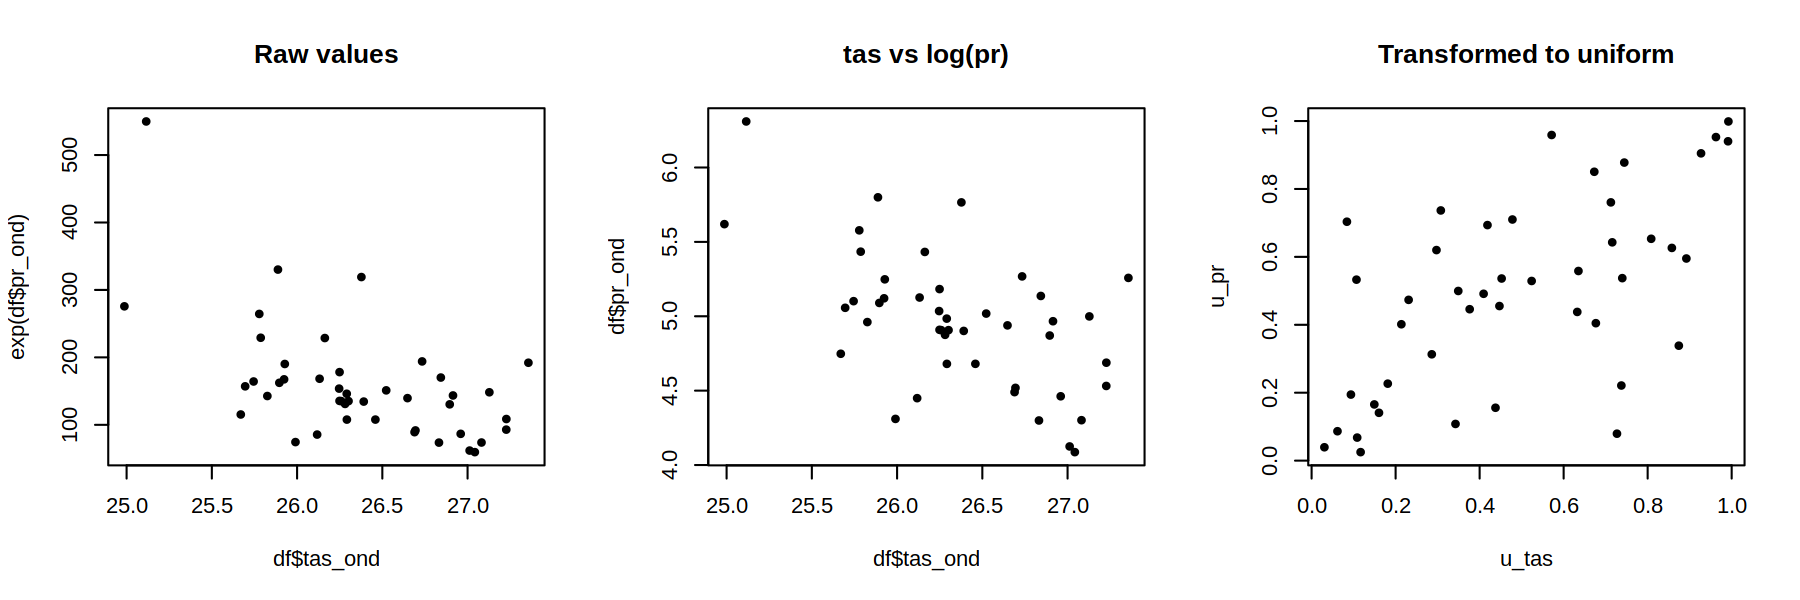

In [58]:
# scatterplot of the data (before, during & after transformation)
rc = c(1,3); options(repr.plot.width = rc[2]*3, repr.plot.height = rc[1]*3, repr.plot.res = 200); par(mfrow = rc, pch = 20)

plot(df$tas_ond, exp(df$pr_ond), main = "Raw values")
plot(df$tas_ond, df$pr_ond, main = "tas vs log(pr)")
plot(u_tas, u_pr, main = "Transformed to uniform")

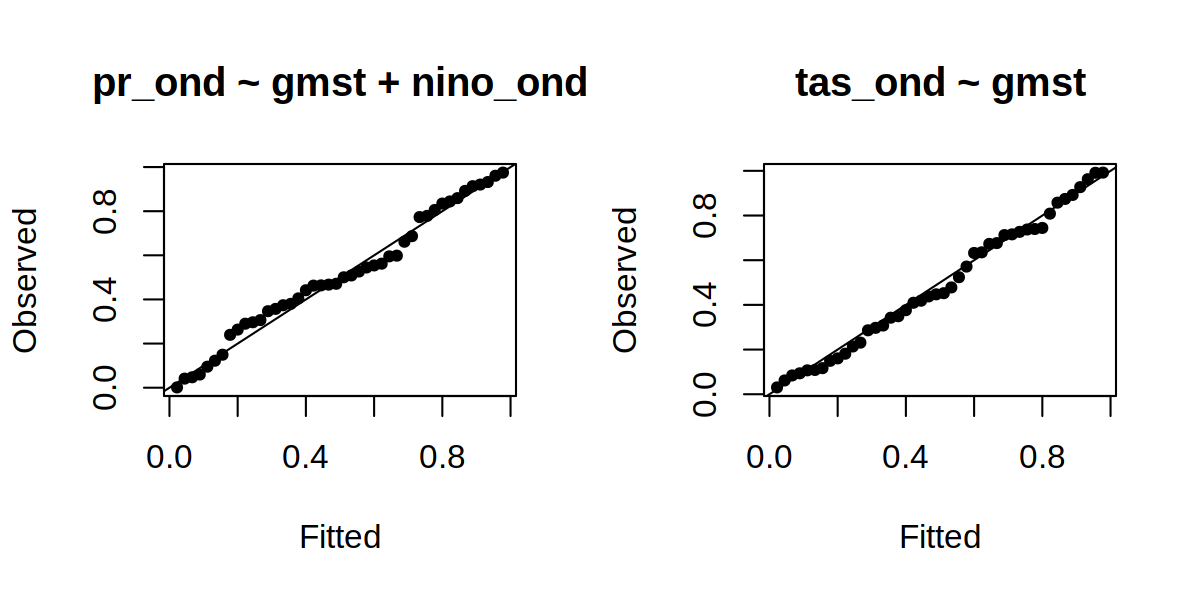

In [59]:
# Q-Q plots of marginal fit
rc = c(1,2); options(repr.plot.width = rc[2]*3, repr.plot.height = rc[1]*3, repr.plot.res = 200); par(mfrow = rc, pch = 20)

plot(seq(0,1,length.out = length(mdl_pr$x)+2)[2:(length(mdl_pr$x)+1)], sort(transform(mdl_pr)), pch = 20, xlab = "Fitted", ylab = "Observed", main = "pr_ond ~ gmst + nino_ond")
abline(0,1)

plot(seq(0,1,length.out = length(mdl_tas$x)+2)[2:(length(mdl_tas$x)+1)], sort(transform(mdl_tas)), pch = 20, xlab = "Fitted", ylab = "Observed", main = "tas_ond ~ gmst")
abline(0,1)


In [60]:
# fit the copula
cfit <- suppressWarnings(fitCopula(tCopula(), data = cbind(u_tas, u_pr)))  # warning message about using df.fixed is irrelevant: can't change this setting

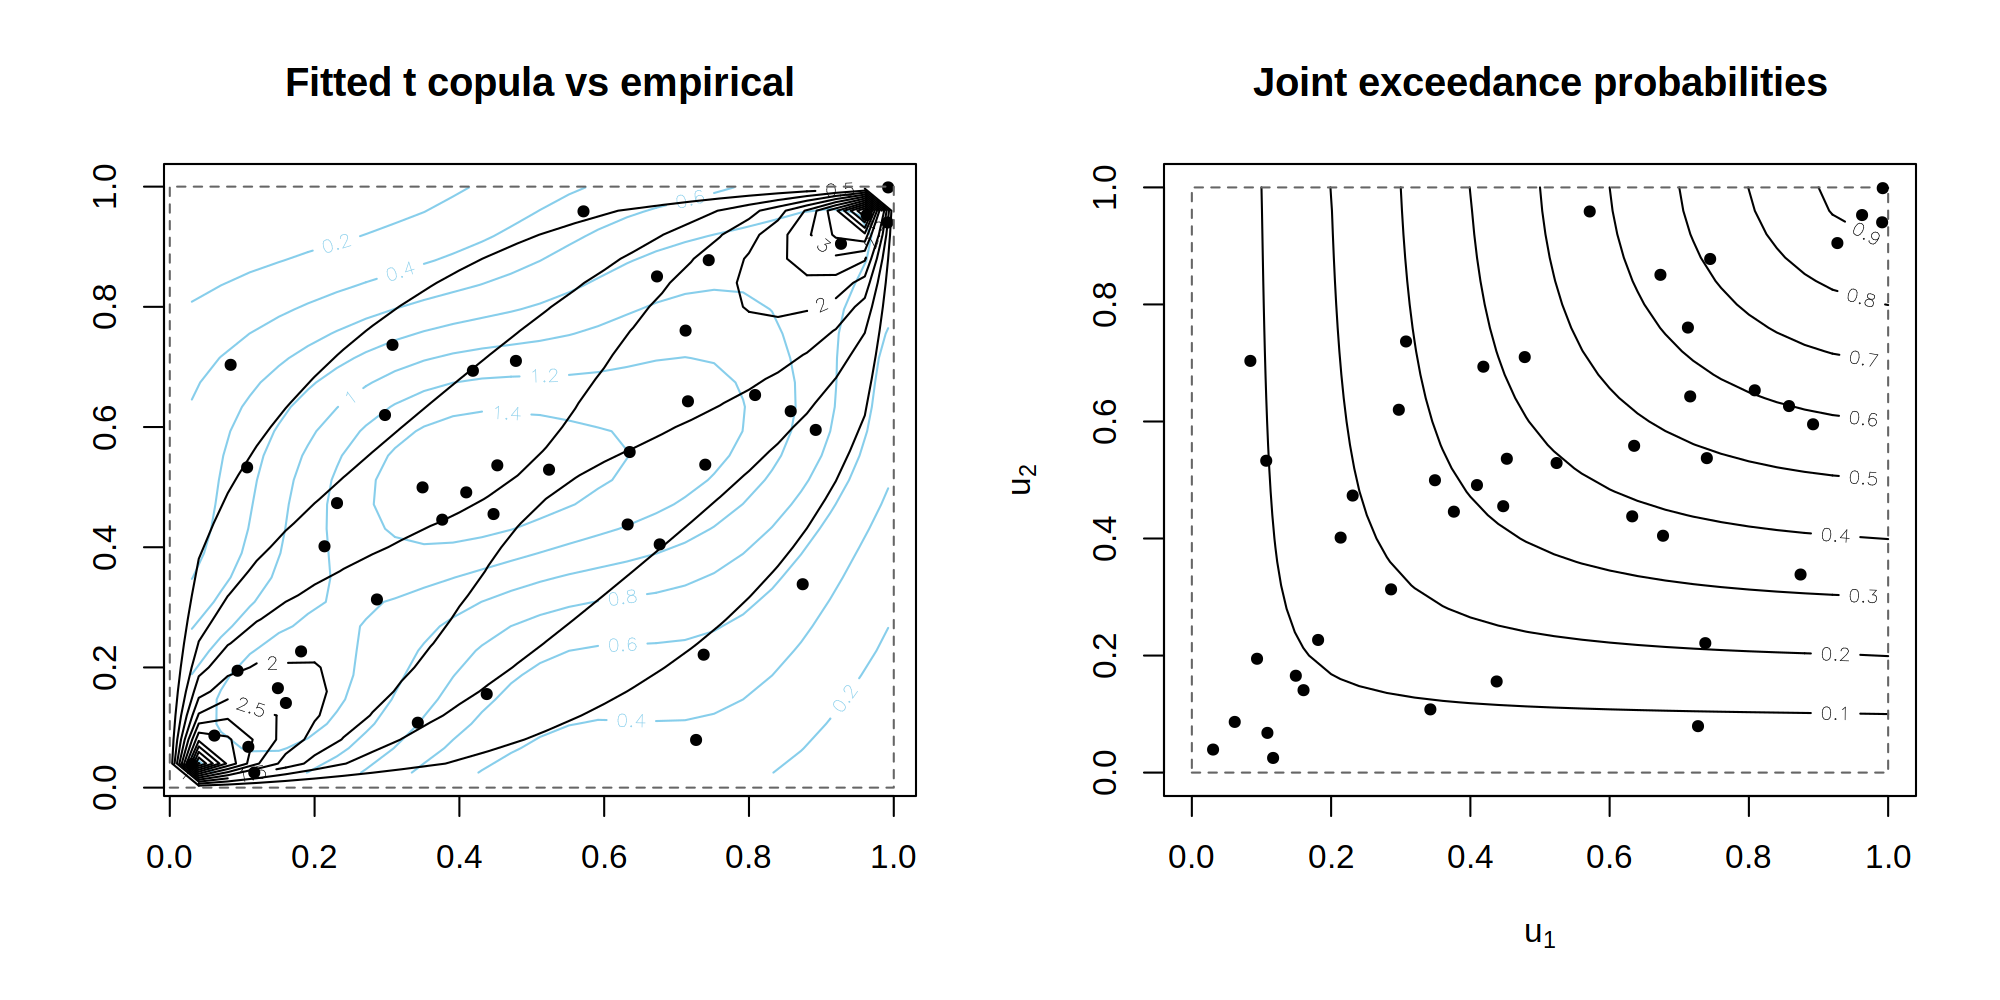

In [61]:
# overplot empirical contours (blue) with copula contours(black) & obs (black points)
rc = c(1,2); options(repr.plot.width = rc[2]*5, repr.plot.height = rc[1]*5, repr.plot.res = 200); par(mfrow = rc, pch = 20)

contour(kde2d(u_tas, u_pr), col = "skyblue", main = "Fitted t copula vs empirical")
points(u_tas, u_pr, pch = 20)
contour(tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"], 0)), dCopula, add = T)

contour(tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"], 0)), pCopula, main = "Joint exceedance probabilities")
points(u_tas, u_pr, pch = 20)

In [62]:
pr_y <- seq(50, 700,length.out = 32)
tas_x <- seq(24.5, 29, length.out = 32)

In [63]:
gmst_2022 = df$gmst[df$year == 2022]

In [64]:
pr_pars_2022 <- mdl_pr$par[c("mu0", "sigma0")] * exp(mdl_pr$par["alpha"] * gmst_2022 / mdl_pr$par["mu0"])
tas_pars_2022 <- mdl_tas$par[c("mu0", "sigma0")] * exp(mdl_tas$par["alpha"] * gmst_2022 / mdl_tas$par["mu0"])

pr_pars_hist <- mdl_pr$par[c("mu0", "sigma0")] * exp(mdl_pr$par["alpha"] * (gmst_2022 - 1.2) / mdl_pr$par["mu0"])
tas_pars_hist <- mdl_tas$par[c("mu0", "sigma0")] * exp(mdl_tas$par["alpha"] * (gmst_2022 - 1.2) / mdl_tas$par["mu0"])

In [65]:
pr_u_2022 <- pnorm(log(pr_y), pr_pars_2022["mu0"], pr_pars_2022["sigma0"])
tas_v_2022 <- pnorm(tas_x, tas_pars_2022["mu0"], tas_pars_2022["sigma0"])

pr_u_hist <- pnorm(log(pr_y), pr_pars_hist["mu0"], pr_pars_hist["sigma0"])
tas_v_hist <- pnorm(tas_x, tas_pars_hist["mu0"], tas_pars_hist["sigma0"])

In [66]:
zcop_2022 <- sapply(1:32, function(j) sapply(32:1, function(i) pCopula(cbind(pr_u_2022[i], tas_v_2022[j]), 
                                                                       tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"], 0)))))
                                             
zcop_hist <- sapply(1:32, function(j) sapply(32:1, function(i) pCopula(cbind(pr_u_hist[i], tas_v_hist[j]), 
                                                                       tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"], 0)))))

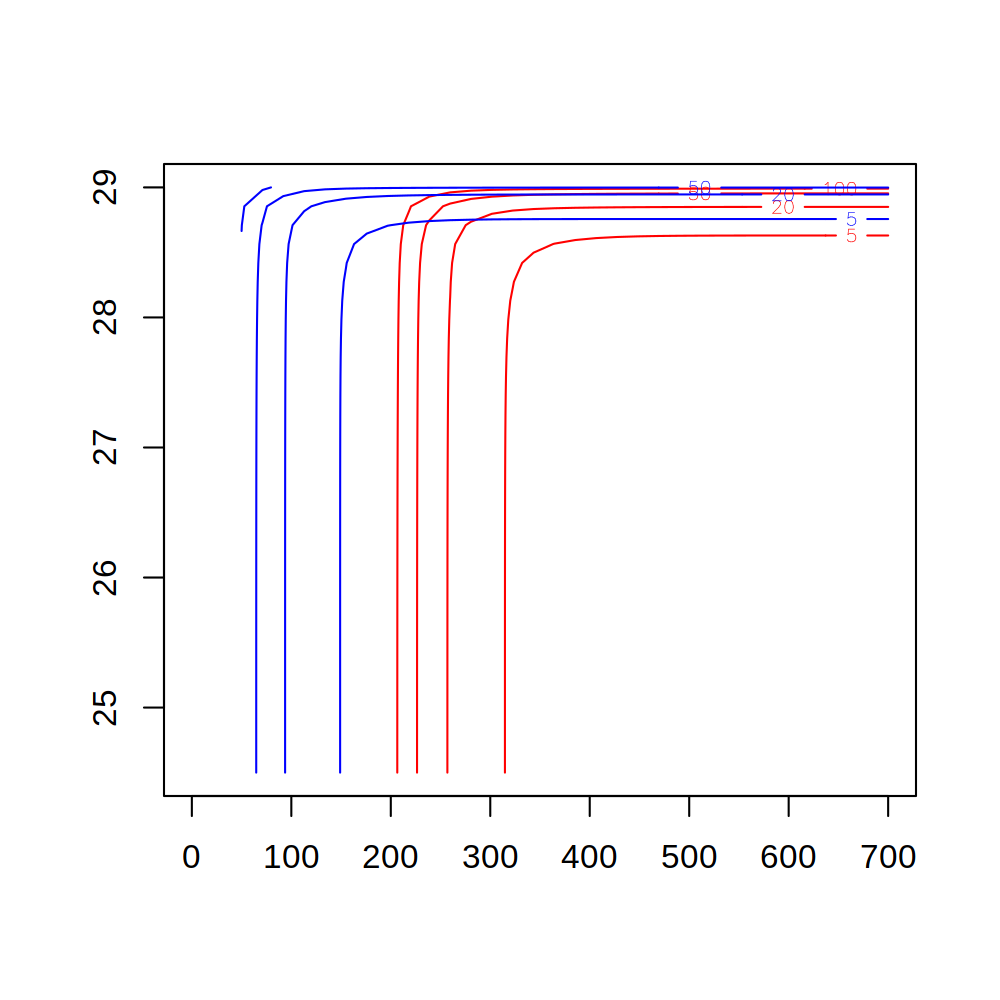

In [242]:
rc = c(1,1); options(repr.plot.width = rc[2]*5, repr.plot.height = rc[1]*5, repr.plot.res = 200); par(mfrow = rc, pch = 20)
yy <- c(5,20,50,100)

contour(pr_y, tas_x, t(zcop_2022), col = "red", levels = 1/yy, labels = yy, ylim = c(24.5, 29), xlim = c(0,700))
points(exp(df$pr_ond[df$year == 2022]), df$tas_ond[df$year == 2022], col = "darkred")
contour(pr_y, tas_x, t(zcop_hist), col = "blue", levels = 1/yy, labels = yy, add = T)

### **Bivariate fitting**

In [257]:
df <- read.csv("data/gmst-nino-cpc.csv")
gmst_2022 <- df$gmst[df$year == 2022]
yy = c(5,10,20,50,100,500)

# fit marginal distributions, transform to uniform
mdl_pr <- flnorm("pr_ond", "gmst", df, "fixeddisp")
pars_pr <- sapply(mdl_pr$results$par[c("mu0", "sigma0")], "*", exp(mdl_pr$results$par["alpha"] * df[,"gmst"] / mdl_pr$results$par["mu0"]))
u_pr <- plnorm(df$pr_ond, mean = pars_pr[,"mu0"], sd = pars_pr[,"sigma0"], lower.tail = T)

mdl_tas <- suppressWarnings(fnorm("tas_ond", "gmst", df, "shift"))
pars_tas <- list("mu" = mdl_tas$results$par["mu0"] + mdl_tas$results$par["alpha"] * df$gmst, "sigma" = mdl_tas$results$par["sigma0"])
u_tas <- pnorm(df$tas_ond, mean = pars_tas$mu, sd = pars_tas$sigma, lower.tail = F)

# fit t copula to transformed marginals 
cfit <- fitCopula(tCopula(), data = cbind(u_tas, u_pr), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't change this setting
cfit <- tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"], 0))

# # get stationary marginal distributions in present climate
# pr_2022 <- qlnorm(u_pr, mean = pars_pr[df$year == 2022, "mu0"], sd = pars_pr[df$year == 2022, "sigma0"], lower.tail = T)
# tas_2022 <- qnorm(u_tas, mean = pars_tas$mu[df$year == 2022], sd = pars_tas$sigma, lower.tail = F)

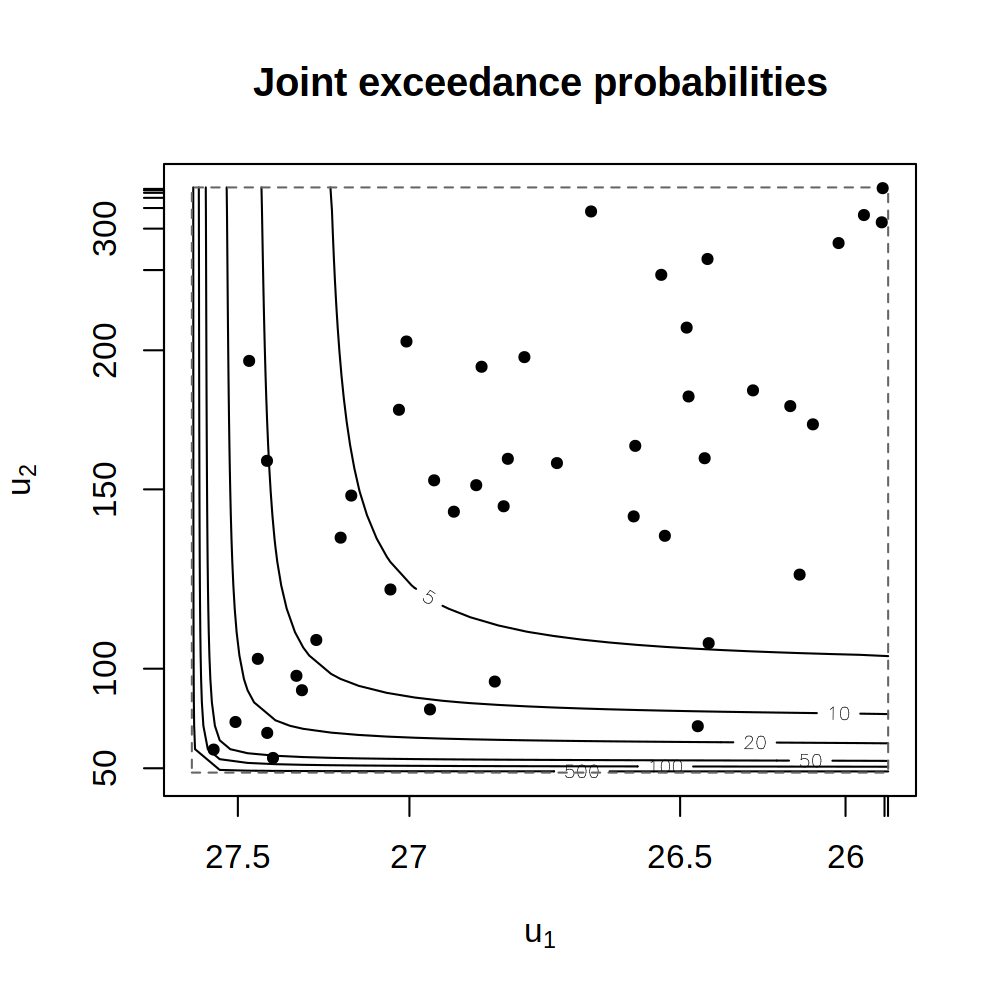

In [258]:
# plot contours against u,v
contour(cfit, pCopula, main = "Joint exceedance probabilities", levels = 1/yy, labels = yy, xaxt = "n", yaxt = "n")
axis(1, at = pnorm(seq(25,27.5,0.5), mean = pars_tas$mu[df$year == 2022], sd = pars_tas$sigma, lower.tail = F), labels = seq(25,27.5,0.5))
axis(2, at = plnorm(seq(50,550,50), mean = pars_pr[df$year == 2022, "mu0"], sd = pars_pr[df$year == 2022, "sigma0"], lower.tail = T), labels = seq(50,550,50))

points(u_tas, u_pr, pch = 20)

In [362]:
# direct plotting using copula doesn't seem to be able to account for one low, one high exceedance - use a mesh instead
n <- 32  # define dimensions of mesh

u_mesh <- seq(0,1,length.out = n)
z_u <- sapply(1:n, function(j) sapply(n:1, function(i) pCopula(cbind(u_mesh[i], u_mesh[j]), cfit)))
                                      
tas_mesh <- seq(24.5, 28.5, length.out = n)
pr_mesh <- seq(25, 300,length.out = n)

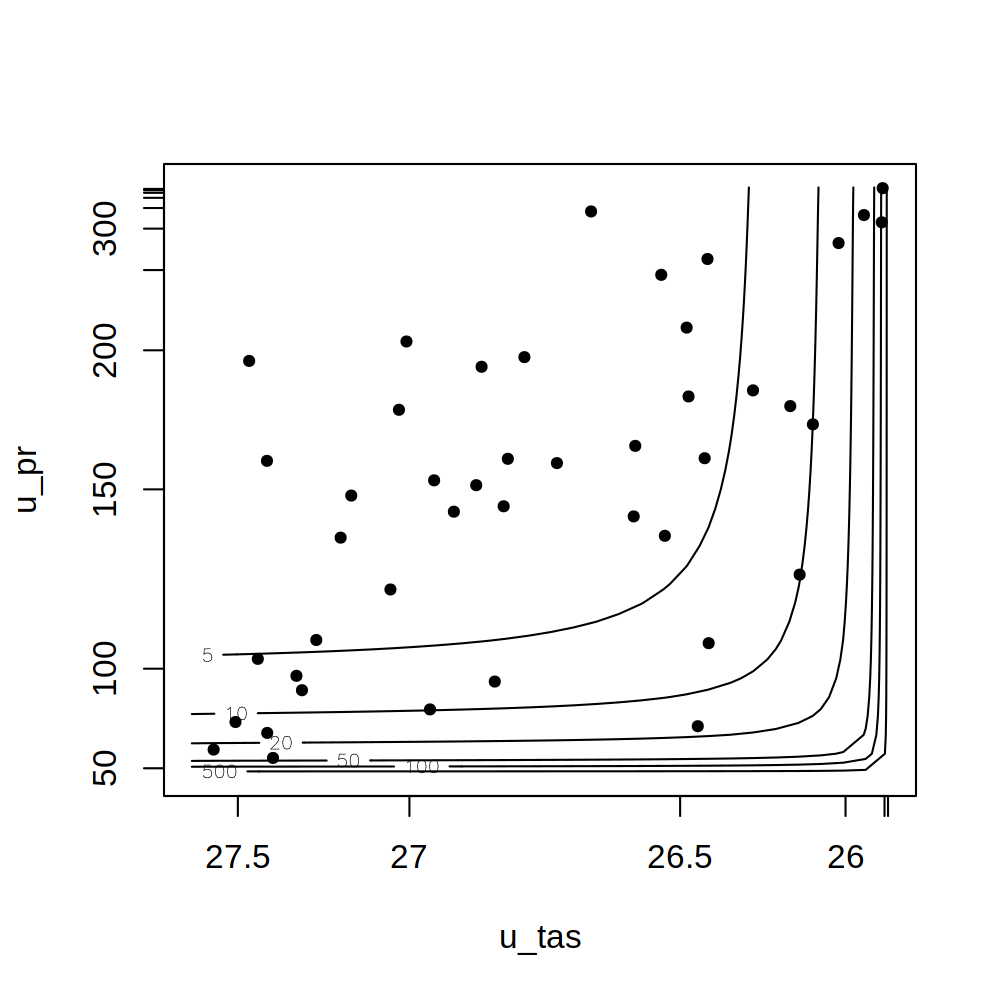

In [363]:
contour(u_mesh, u_mesh, z_u, xaxt = "n", yaxt = "n", xlab = "u_tas", ylab = "u_pr", levels = 1/yy, labels = yy)
axis(1, at = pnorm(seq(25,27.5,0.5), mean = pars_tas$mu[df$year == 2022], sd = pars_tas$sigma, lower.tail = F), labels = seq(25,27.5,0.5))
axis(2, at = plnorm(seq(50,550,50), mean = pars_pr[df$year == 2022, "mu0"], sd = pars_pr[df$year == 2022, "sigma0"], lower.tail = T), labels = seq(50,550,50))
points(u_tas, u_pr, pch = 20)

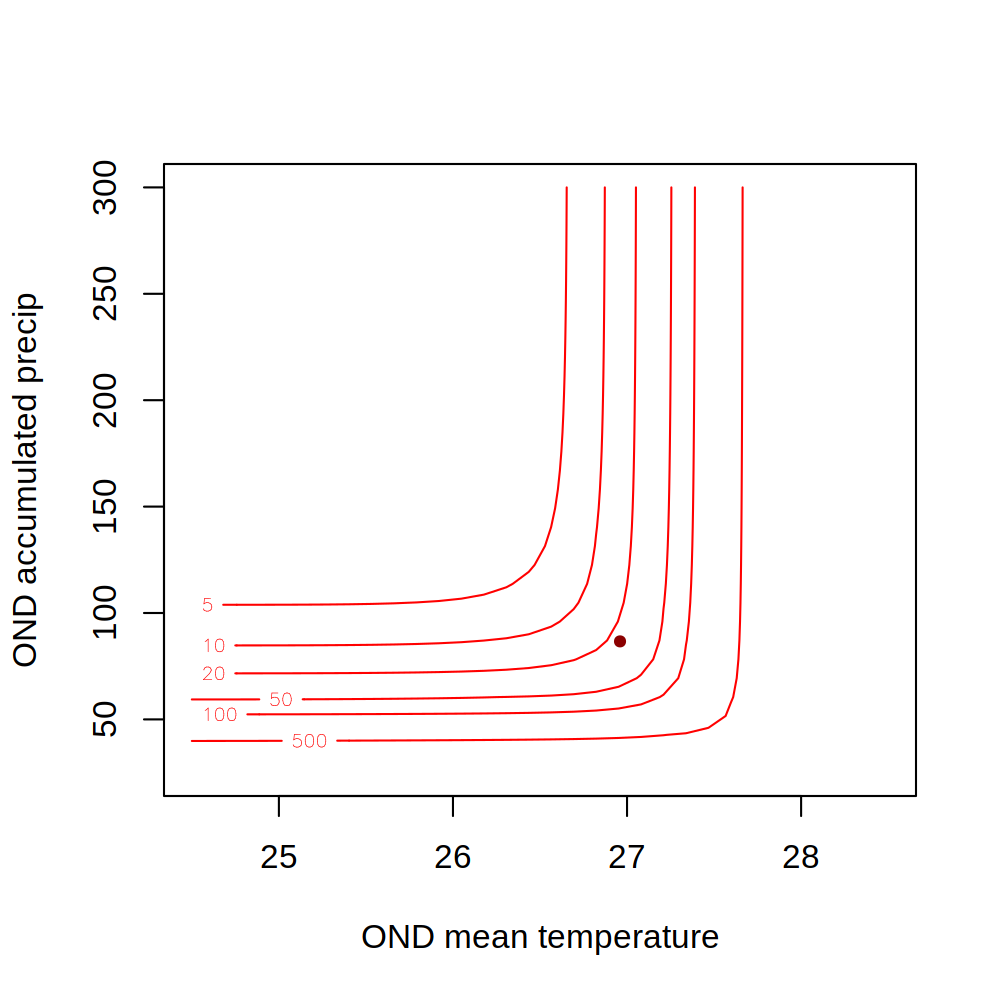

In [364]:
u_tas_2022 <- pnorm(tas_mesh, mean = pars_tas$mu[df$year == 2022], sd = pars_tas$sigma, lower.tail = T)
u_pr_2022 <- plnorm(pr_mesh, mean = pars_pr[df$year == 2022,"mu0"], sd = pars_pr[df$year == 2022,"sigma0"], lower.tail = T)
z_2022 <- sapply(1:n, function(j) sapply(n:1, function(i) pCopula(cbind(u_tas_2022[i], u_pr_2022[j]), cfit)))

contour(tas_mesh, pr_mesh, z_2022, xlab = "OND mean temperature", ylab = "OND accumulated precip", levels = 1/yy, labels = yy, col = "red")
points(df$tas_ond[df$year == 2022], df$pr_ond[df$year == 2022], pch = 20, col = "darkred")
                                         
# add marginals to see if that helps untangle what's happening here

Warning message in rug(df$pr_ond, side = 2):
“some values will be clipped”


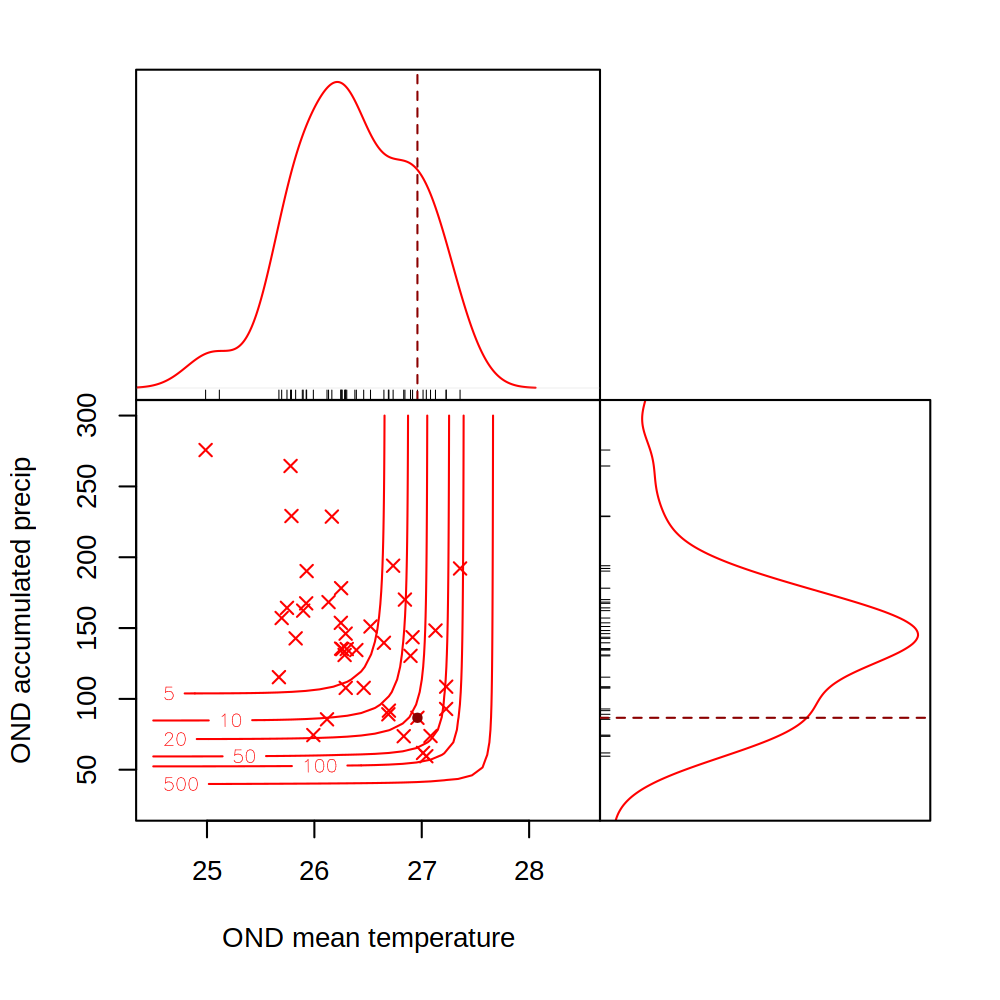

In [365]:
layout(matrix(c(1,2,3,4),2,2), widths = c(3,2), heights = c(2,3))

par(mar = c(0,4.1,2.1,0))
plot(density(df$tas_ond), xaxt = "n", yaxt = "n", xlab = "", xlim = range(tas_mesh), ylab = "", main = "", col = "red")
rug(df$tas_ond)
abline(v = df$tas_ond[df$year == "2022"], col = "darkred", lty = 2)

par(mar = c(5.4,4.1,0,0))
contour(tas_mesh, pr_mesh, z_2022, xlab = "OND mean temperature", ylab = "OND accumulated precip", levels = 1/yy, labels = yy, col = "red")
points(df$tas_ond, df$pr_ond, pch = 4 ,col = "red")
points(df$tas_ond[df$year == 2022], df$pr_ond[df$year == 2022], pch = 20, col = "darkred")

plot.new()
# par(mar = c(0,0,2.1,2.1))
# contour(kde2d(u_tas, u_pr), col = "skyblue", main = "", xaxt = "n", yaxt = "n")
# points(u_tas, u_pr, pch = 4)
# contour(cfit, dCopula, add = T)

par(mar = c(5.4,0,0,2.1))
dns <- density(df$pr_ond)
plot(dns$y, dns$x, yaxt = "n", xaxt = "n", xlab = "", ylim = range(pr_mesh), type = "l", col = "red")
rug(df$pr_ond, side = 2)
abline(h = df$pr_ond[df$year == "2022"], col = "darkred", lty = 2)

# probably better to replot with CDF on each axis? Or return level plot?

---
# **Fitting with `mvdc`**

In [68]:
df <- read.csv("data/gmst-nino-cpc.csv")
gmst_2022 <- df$gmst[df$year == 2022]

In [107]:
# fit marginal distributions
mdl_pr <- fit_nsfd("lnorm", df, "pr_ond", "gmst")
mdl_tas <- fit_nsfd("norm", df, "tas_ond", "gmst")

# transform observed values to stationary uniform distribution
u_pr <- transform(mdl_pr, lower = T)
u_tas <- transform(mdl_tas, lower = F)

# fit t copula to transformed marginals 
cfit <- fitCopula(tCopula(), data = cbind(u_tas, u_pr), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't change this setting

# get stationary marginal distributions in present & past climate
pr_2022 <- transform(mdl_pr, cov1 = gmst_2022)
tas_2022 <- transform(mdl_tas, cov1 = gmst_2022)

pr_hist <- transform(mdl_pr, cov1 = gmst_2022 - 1.2)
tas_hist <- transform(mdl_tas, cov1 = gmst_2022 - 1.2)

In [108]:
mvdc_2022 <- mvdc(tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"],0)),
                margins = c("norm","lnorm"), 
                paramMargins = list(as.list(fitdistr(tas_2022, "normal")$est), as.list(fitdistr(pr_2022, "lognormal")$est)))

mvdc_hist <- mvdc(tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"],0)),
                margins = c("norm","lnorm"), 
                paramMargins = list(as.list(fitdistr(tas_hist, "normal")$est), as.list(fitdistr(pr_hist, "lognormal")$est)))

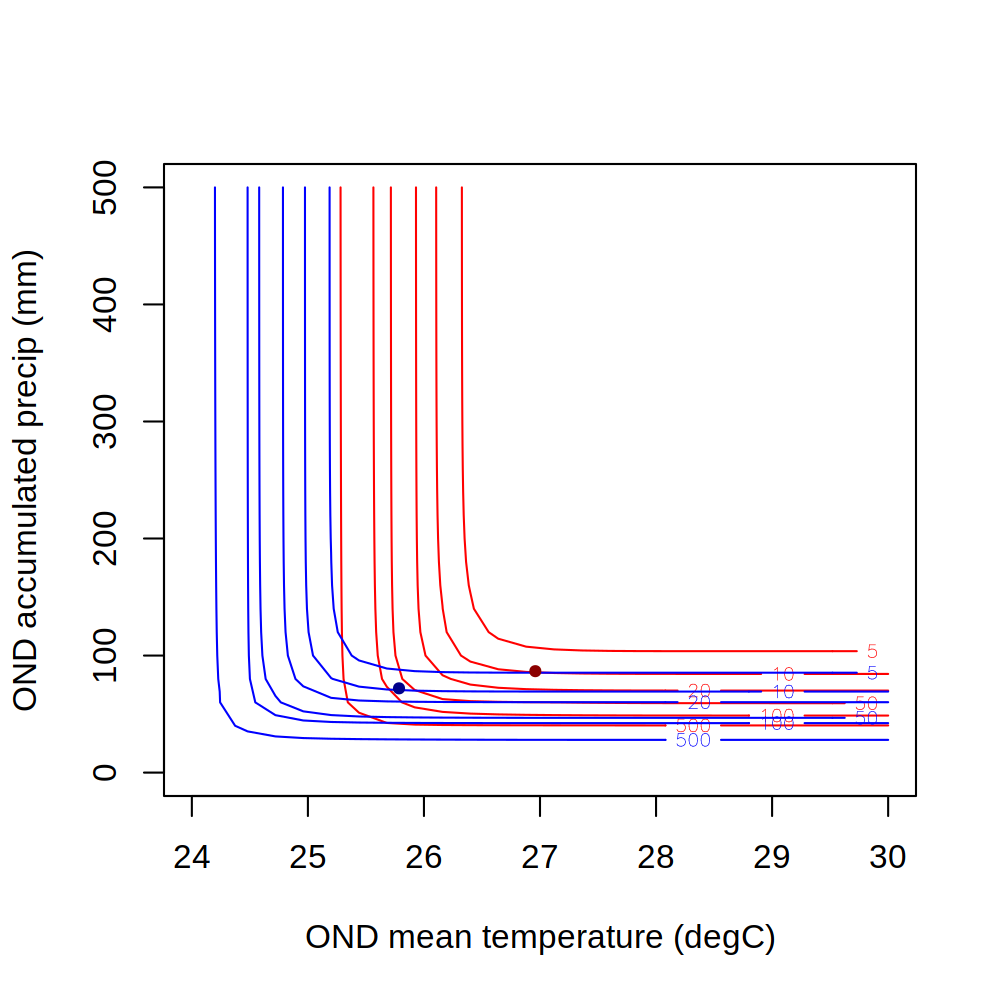

In [118]:
yy = c(5,10,20,50,100,500)

contour(mvdc_2022, pMvdc, xlim = c(24,30), ylim = c(0,500), levels = 1/yy, labels = yy, col = "red",
        xlab = "OND mean temperature (degC)", ylab = "OND accumulated precip (mm)")
contour(mvdc_hist, pMvdc, xlim = c(24,30), ylim = c(0,500), levels = 1/yy, labels = yy, col = "blue", add = T)
# points(tas_2022, pr_2022, pch = 4, col = "red")
# points(tas_hist, pr_hist, pch = 4, col = "blue")

points(tas_2022[df$year == 2022], pr_2022[df$year == 2022], col = "darkred", pch = 20)
points(tas_hist[df$year == 2022], pr_hist[df$year == 2022], col = "darkblue", pch = 20)

---
## **Fitting using lognormal distribution directly**
- possible preferable method: use R to fit lognormal distribution, transform data to current lognormal, and fit/plot copula to that data?

In [774]:
source("../methods_extRemes.r")
library("copula")

df <- read.csv("data/gmst-nino-cpc.csv")
df["log10_ond"] <- log10(df$pr_ond)
df["logn_ond"] <- log(df$pr_ond)

### **Check lognormal fit vs log fit**

In [786]:
# check that fitting method gives same result as Climate Explorer
fit_nsfd("norm", df, "log10_ond", "gmst")$par       # climate explorer has 2.114, 0.193, 0.076

mu0     sigma0      alpha       beta 
2.11429860 0.19267739 0.07481004 0.00000000

In [791]:
# check that lognormal fitting method gives same result as normal fitting to log_pr
fit_nsfd("norm", df, "logn_ond", "gmst")$par    # check fitted pars using exactly same method, but with natural log
fit_nsfd("lnorm", df, "pr_ond", "gmst")$par     # results are basically identical to when fitting normal to log_pr (as they should be!)

mu0    sigma0     alpha      beta 
4.8683524 0.4436561 0.1722565 0.0000000

mu0    sigma0     alpha      beta 
4.8677692 0.4435051 0.1730797 0.0000000

In [793]:
lnorm_fixeddisp_2cov <- function(pars = c(mu0, sigma0, alpha, beta), cov1, cov2, x) {
    
    const = exp((pars["alpha"] * cov1 + pars["beta"] * cov2) / pars["mu0"])
    loc = pars["mu0"] * const
    scale = pars["sigma0"] * const
    
    # return negative log-likelihood to be minimised
    return(-sum(dlnorm(x, mean = loc, sd = scale, log = T)))
}

mu0    sigma0     alpha      beta 
4.8073091 0.3835736 0.3080471 0.1834380

mu0    sigma0     alpha      beta 
4.7582622 0.4038701 0.3826730 0.2052600

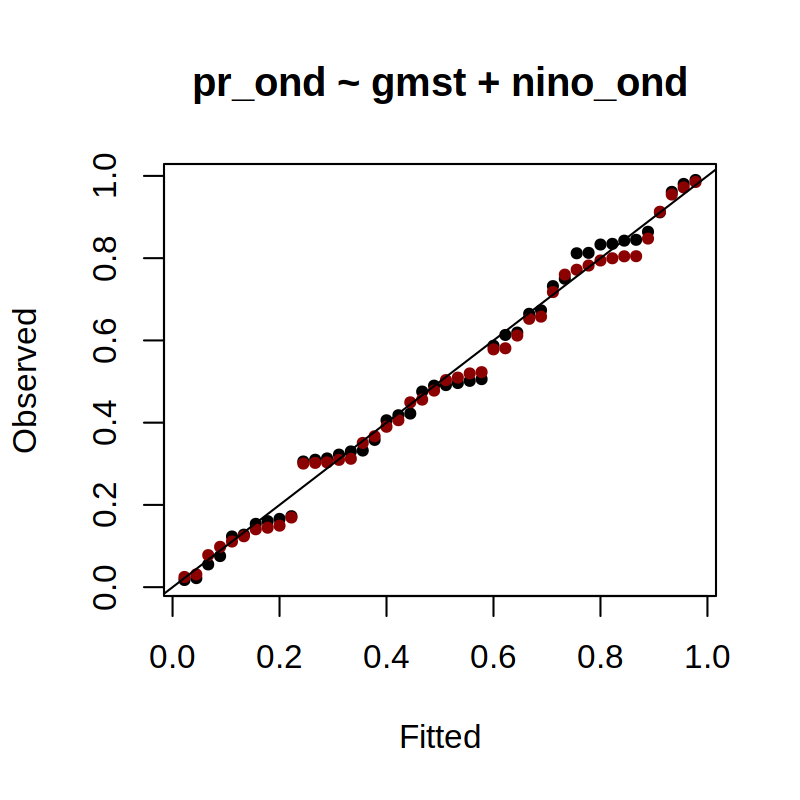

In [806]:
# slight difference in the parameters, but nothing drastic
fit_nsfd("norm", df, "logn_ond", "gmst", "nino_ond")$par
fit_nsfd("lnorm", df, "pr_ond", "gmst", "nino_ond")$par

# which gives the better fit?
rc = c(1,1); options(repr.plot.width = rc[2]*4, repr.plot.height = rc[1]*4, repr.plot.res = 200); par(mfrow = rc, pch = 20)

plot(seq(0,1,length.out = length(mdl$x)+2)[2:(length(mdl$x)+1)],
     sort(transform(fit_nsfd("norm", df, "logn_ond", "gmst", "nino_ond"))), 
     pch = 20, xlab = "Fitted", ylab = "Observed", main = "pr_ond ~ gmst + nino_ond")
points(seq(0,1,length.out = length(mdl$x)+2)[2:(length(mdl$x)+1)],
     sort(transform(fit_nsfd("lnorm", df, "pr_ond", "gmst", "nino_ond"))), col = "darkred")
abline(0,1)

# very slight difference - not sure if easier for plotting, but makes no difference when fitting the model.
# will retain both methods and see if it makes a difference later.

### **Fit multivariate model with copula**

In [807]:
# start by fittin marginal distributions, as previously
mdl_pr <- fit_nsfd("lnorm", df, "pr_ond", "gmst")
mdl_tas <- fit_nsfd("norm", df, "tas_ond", "gmst")

# transform observed values to stationary distribution expected in current climate
gmst_2022 <- df$gmst[df$year == 2022]
nino_2022 <- df$nino_ond[df$year == 2022]

s_pr <- transform(mdl_pr, cov1 = gmst_2022, cov2 = nino_2022, lower = T)
s_tas <- transform(mdl_tas, cov1 = gmst_2022, cov2 = nino_2022)

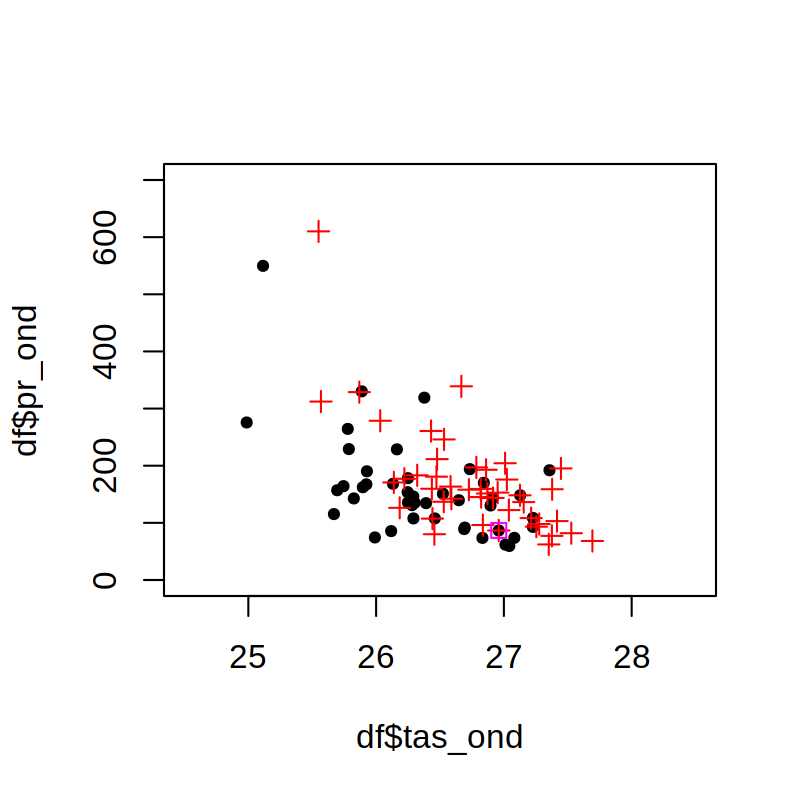

In [556]:
# let's just see what that transformation looks like

rc = c(1,1); options(repr.plot.width = rc[2]*4, repr.plot.height = rc[1]*4, repr.plot.res = 200); par(mfrow = rc, pch = 20)

plot(df$tas_ond, df$pr_ond, ylim = c(0,700), xlim = c(24.5,28.5))
points(s_tas, s_pr, pch = 3, col = "red")
points(df$tas_ond[df$year == 2022], df$pr_ond[df$year == 2022], col = "magenta", pch = 0) # 2022 value is unchanged

In [573]:
# does fitting to the transformed data give the expected parameters of the stationary distribution?
mdl_pr$par[c("mu0", "sigma0")] * exp(mdl_pr$par["alpha"] * gmst_2022 / mdl_pr$par["mu0"])
fitdistr(s_pr, "lognormal")$est

mdl_tas$par[c("mu0", "sigma0")] * exp(mdl_tas$par["alpha"] * gmst_2022 / mdl_tas$par["mu0"])
fitdistr(s_tas, "normal")$est

mu0    sigma0 
5.0294866 0.4582393

meanlog     sdlog 
5.0296387 0.4583526

mu0     sigma0 
26.7573820  0.4994992

mean         sd 
26.7573987  0.4994914

In [678]:
# yes. In which case, we should be able to use mvdc to fit the whole lot at once...
my_mvdc <- mvdc(tCopula(), margins = c("norm","lnorm"), paramMargins = list(as.list(fitdistr(s_tas, "normal")$est), as.list(fitdistr(s_pr, "lognormal")$est)))
fitted <- fitMvdc(cbind(s_tas, s_pr), my_mvdc, start = c(fitdistr(s_tas, "normal")$est, fitdistr(s_pr, "lognormal")$est, coef(cfit)))

In [685]:
rMvdc(100,fitted)

ERROR: Error in rMvdc(100, fitted): no slot of name "copula" for this object of class "fitMvdc"


In [687]:
# or perhaps not. Try fitting the components separately as before, should be exactly equivalent
u_pr <- transform(mdl_pr, lower = T)
u_tas <- transform(mdl_tas)
cfit <- suppressWarnings(fitCopula(tCopula(), data = cbind(u_tas, u_pr)))

my_mvdc <- mvdc(tCopula(coef(cfit)["rho.1"], df = round(coef(cfit)["df"], 0)),
                margins = c("norm","lnorm"), 
                paramMargins = list(as.list(fitdistr(s_tas, "normal")$est), as.list(fitdistr(s_pr, "lognormal")$est)))

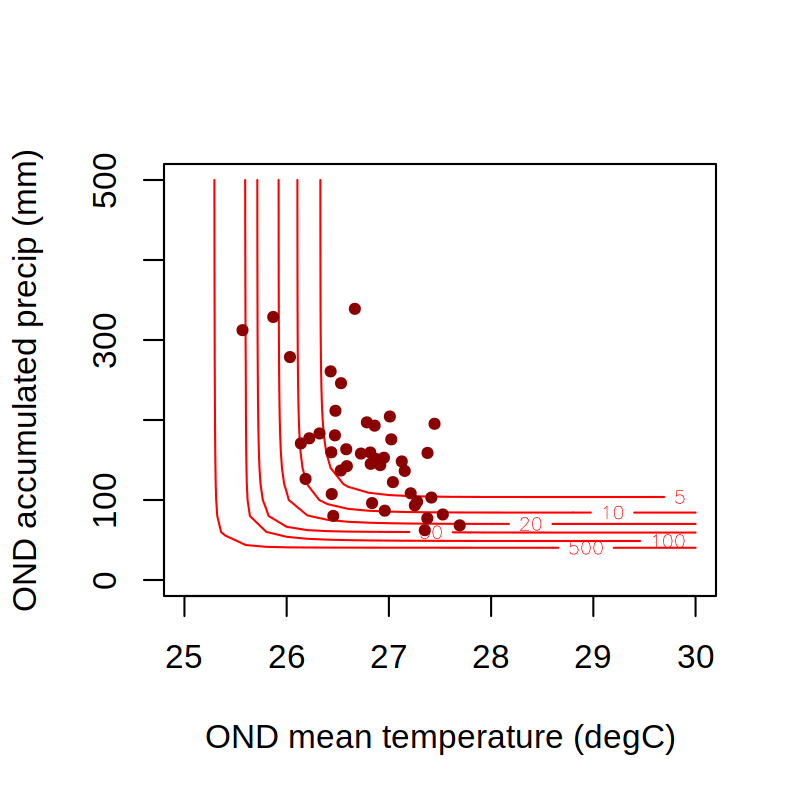

In [713]:
yy = c(5,10,20,50,100,500)

contour(my_mvdc, pMvdc, xlim = c(25,30), ylim = c(0,500), levels = 1/yy, labels = yy, col = "red",
        xlab = "OND mean temperature (degC)", ylab = "OND accumulated precip (mm)")
points(s_tas, s_pr, pch = 20, col = "darkred")

# doesn't seem to be possible to look at lower tail of precip + upper tail of temperature